Stability analysis in the theta model

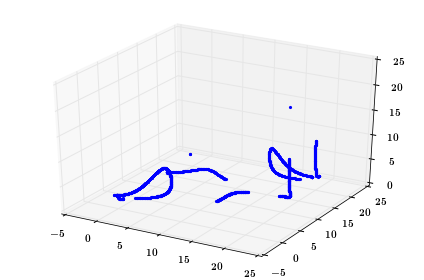

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from generate_figures import get_antiphase, get_antiphase_fulltheta
from mpl_toolkits.mplot3d import proj3d

mod = np.mod

# load dat files
namexx = 'h11_tbwb_eps=0.0025_mux=1.0_muy=1.0_gee=10.0_gei=24.0_gie=13.0_gii=10.0_N=2.dat'
namexy = 'h12_tbwb_eps=0.0025_mux=1.0_muy=1.0_gee=10.0_gei=24.0_gie=13.0_gii=10.0_N=2.dat'
nameyx = 'h21_tbwb_eps=0.0025_mux=1.0_muy=1.0_gee=10.0_gei=24.0_gie=13.0_gii=10.0_N=2.dat'
nameyy = 'h22_tbwb_eps=0.0025_mux=1.0_muy=1.0_gee=10.0_gei=24.0_gie=13.0_gii=10.0_N=2.dat'

datxx=np.loadtxt(namexx);datxy=np.loadtxt(namexy);datyx=np.loadtxt(nameyx);datyy=np.loadtxt(nameyy)
per = datxx[-1,0]

hxx_interp = interp1d(datxx[:,0],datxx[:,1])
hyx_interp = interp1d(datyx[:,0],datyx[:,1])

def hxx(x):
    #print x,'hxxin'
    x = mod(x,per)
    return hxx_interp(x)

def hxy(x,tau):
    x = mod(x,per)
    hxy_interp = interp1d(datxy[:,0],datxy[:,1]/tau)
    return hxy_interp(x)

def hyx(x):
    x = mod(x,per)
    return hyx_interp(x)

def hyy(x,tau):
    x = mod(x,per)
    hyy_interp = interp1d(datyy[:,0],datyy[:,1]/tau)
    return hyy_interp(x)


tau = 2.62


def rhs(px,py,pz,tau):
    """
    RHS of theta model phase equations
    """
    
    rhs_x=hxx(-px)-hxx(px)+hxy(-px+pz,tau)-hxy(pz,tau)+hxy(py-px+pz,tau)-hxy(py+pz,tau)
    rhs_y=hyx(-py-pz)-hyx(-pz)+hyy(-py,tau)+hyx(px-py-pz)-hyx(px-pz)-hyy(py,tau)
    rhs_z=hyx(-pz)+hyy(0,tau)+hyx(px-pz)+hyy(py,tau)-hxx(0)-hxy(pz,tau)-hxx(px)-hxy(py+pz,tau)
    
    return np.array([rhs_x,rhs_y,rhs_z])


    
dhxx_interp = interp1d(datxx[:,0],np.gradient(hxx(datxx[:,0]),np.diff(datxx[:,0])[0]))
dhyx_interp = interp1d(datyx[:,0],np.gradient(hyx(datyx[:,0]),np.diff(datyx[:,0])[0]))


def dhxx(x):
    x = mod(x,per)
    return dhxx_interp(x)

def dhxy(x,tau):
    x = mod(x,per)
    dhxy_interp = interp1d(datxy[:,0],np.gradient(hxy(datxy[:,0],tau),np.diff(datxy[:,0])[0]))
    return dhxy_interp(x)

def dhyx(x):
    x = mod(x,per)
    return dhyx_interp(x)

def dhyy(x,tau):
    x = mod(x,per)
    dhyy_interp = interp1d(datyy[:,0],np.gradient(hyy(datyy[:,0],tau),np.diff(datyy[:,0])[0]))
    return dhyy_interp(x)

def jac(px,py,pz,tau):
    """
    Jacobian matrix
    """
    j11 = -dhxx(mod(-px,per))-dhxx(mod(px,per))-dhxy(mod(-px+pz,per),tau)-dhxy(mod(py-px+pz,per),tau)
    j12 = dhxy(mod(py-px+pz,per),tau)-dhxy(mod(py+pz,per),tau)
    j13 = dhxy(mod(-px+pz,per),tau)-dhxy(mod(pz,per),tau)+dhxy(mod(py-px+pz,per),tau)-dhxy(mod(py+pz,per),tau)
    
    j21 = dhyx(mod(px-py+pz,per))-dhyx(mod(px-pz,per))
    j22 = -dhyx(mod(-py-pz,per))-dhyx(mod(px-py-pz,per))-dhyy(mod(-py,per),tau)-dhyy(mod(py,per),tau)
    j23 = -dhyx(mod(-py-pz,per))+dhyx(mod(-pz,per))-dhyx(mod(px-py-pz,per))+dhyx(mod(px-pz,per))
    
    j31 = dhyx(mod(px-pz,per))-dhxx(mod(px,per))
    j32 = dhyy(mod(py,per),tau)-dhxy(mod(py+pz,per),tau)
    j33 = -dhyx(mod(-pz,per))-dhyx(mod(px-pz,per))-dhxy(mod(pz,per),tau)-dhxy(mod(py+pz,per),tau)
    
    return np.array([[j11,j12,j13],
                     [j21,j22,j23],
                     [j31,j32,j33]])

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

bifdat = np.loadtxt('tbwb_fixed_pts_pxza0a.ode.bif.dat')

tauvals = bifdat[:,3]
px = bifdat[:,6]
pz = bifdat[:,7]

for i in range(len(tauvals)):
    if sum(np.linalg.eig(jac(px[i],0,pz[i],tauvals[i]))[0])>0:
        ax.scatter(px[i],pz[i],tauvals[i],s=10,color='red',edgecolor='none')
    else:
        ax.scatter(px[i],pz[i],tauvals[i],s=10,color='green',edgecolor='none')
        
fig.savefig('temp.png')

plt.show()